In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob, os, json

Using TensorFlow backend.
C:\Users\hoang\anaconda3\envs\lp_reg\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hoang\anaconda3\envs\lp_reg\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hoang\anaconda3\envs\lp_reg\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hoang\anaconda3\envs\lp_reg\lib\sit

In [2]:
# Loading json file
path_to_json = 'dataset/sharpness/labels/'
labels = []
full_description = []

for file_name in [file for file in os.listdir(path_to_json) if file.endswith('.json')]:
    with open(path_to_json + file_name) as json_file:
        data = json.load(json_file)
        pts = []
        for plate in data['shapes']:
            pts.append(plate['points'])
        full_description.append(data)
        labels.append(pts)

In [3]:
len(labels)

132

In [4]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [5]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)


Loading model successfully...


In [6]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 132 images...


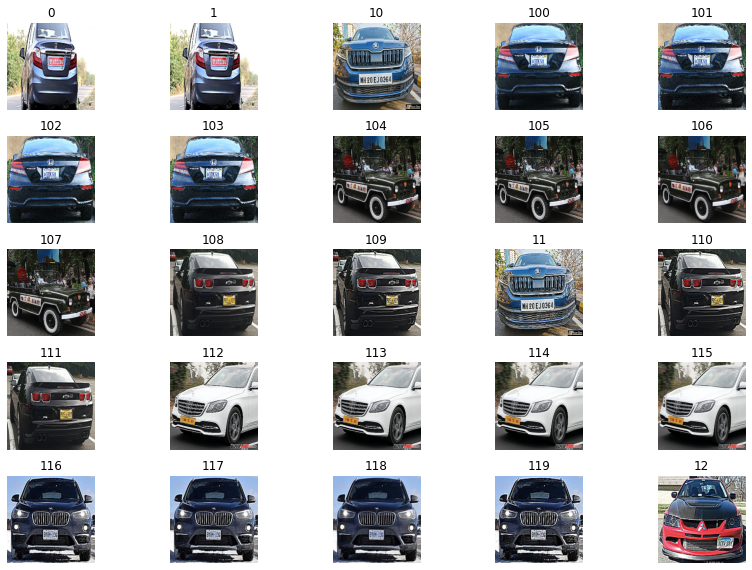

In [7]:
# Create a list of image paths 
image_paths = glob.glob("dataset/sharpness/images/*.png")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 5
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()


Detect 1 plate(s) in 108
Coordinate of plate(s) in image: 
 [array([[171.46599323, 211.7470761 , 211.1782976 , 170.89721473],
       [ 87.7564331 ,  85.81124382, 105.16809497, 107.11328425],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


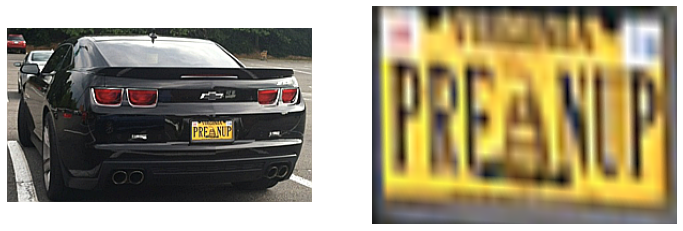

In [8]:
# forward image through model and return plate's image and coordinates
def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    # print("Height {}, Width {}".format(vehicle.shape[0], vehicle.shape[1]) )
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
image_paths = glob.glob("dataset/sharpness/images/*.png")
test_image = image_paths[11]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

# Calculate IOU

In [9]:
def get_XY_coor(X_list, Y_list):
    coor = []
    for i in range(4):
        x = X_list[i]
        y = Y_list[i]
        coor.append([x,y])
    return coor

In [10]:
from shapely.geometry import box, Polygon
def IOU(pol1_xy, pol2_xy):
    # Define each polygon
    polygon1_shape = Polygon(pol1_xy)
    polygon2_shape = Polygon(pol2_xy)

    # intersection
    polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
    
    # union = shape1 + shape2 - union
    polygon_union = polygon1_shape.area + polygon2_shape.area - polygon_intersection
    
    # IOU = intersection / union
    return polygon_intersection / polygon_union

# Calculate AP

In [11]:
def calculate_AP(preList, recList):
    
    pre = preList.copy()
    pre.append(1)
    rec = recList.copy()
    rec.append(0)
    precisions = np.array(pre)
    recalls = np.array(rec)
    ap = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
        
    return ap

In [12]:
image_paths = glob.glob("dataset/sharpness/images/*.png")

In [13]:
len(image_paths)

132

In [14]:
import timeit

iou = []
check = []
for i in range(len(image_paths)):
    test_image = image_paths[i]
    # print(i)
    LpImg,cor = get_plate(test_image)
    if cor == None:
        continue
    if i%10 == 0:
        print(i)
    for p in range(len(LpImg)):
        X = cor[p][0]
        Y = cor[p][1]
        
        coor_predict = get_XY_coor(X, Y)
        maxIOU = 0
        for l in range(len(labels[i])):
            coor_label = labels[i][l]
            maxIOU = max(maxIOU, IOU(coor_label, coor_predict))
        iou.append(maxIOU)
        check.append([i, maxIOU])

0
10
20
30
40
50
60
70
80
90
100
110
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
130


In [15]:
preList = []
recList = []
for alpha in range(50,100,5):
    TP = 0
    FP = 0
    FN = 0
    for i in iou:
        if i > float(alpha/100):
            TP += 1
        elif i == 0:
            FN += 1
        else:
            FP += 1
    
    precision = (TP)/(TP+FP)
    preList.append(precision)
    
    recall = (TP)/(TP+FN)
    recList.append(recall)
    
    print('Threshold: ', alpha, '. Precision: ', precision, '. Recall: ', recall)

Threshold:  50 . Precision:  0.9354838709677419 . Recall:  0.6823529411764706
Threshold:  55 . Precision:  0.9354838709677419 . Recall:  0.6823529411764706
Threshold:  60 . Precision:  0.9354838709677419 . Recall:  0.6823529411764706
Threshold:  65 . Precision:  0.9032258064516129 . Recall:  0.6746987951807228
Threshold:  70 . Precision:  0.7741935483870968 . Recall:  0.64
Threshold:  75 . Precision:  0.7419354838709677 . Recall:  0.6301369863013698
Threshold:  80 . Precision:  0.6290322580645161 . Recall:  0.5909090909090909
Threshold:  85 . Precision:  0.3709677419354839 . Recall:  0.46
Threshold:  90 . Precision:  0.056451612903225805 . Recall:  0.11475409836065574
Threshold:  95 . Precision:  0.0 . Recall:  0.0


In [21]:
calculate_AP(preList, recList)

0.2921408140463659

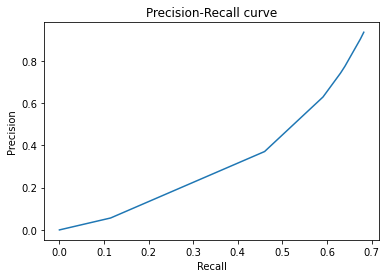

In [22]:
plt.plot(recList, preList)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.savefig("Precision_Recall curve of sharpness augmentation.jpg",dpi=80)

# Draw bounding box

In [23]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the bottom-left, bottom-right, top-right, top-left
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU:  0.8941818692407362


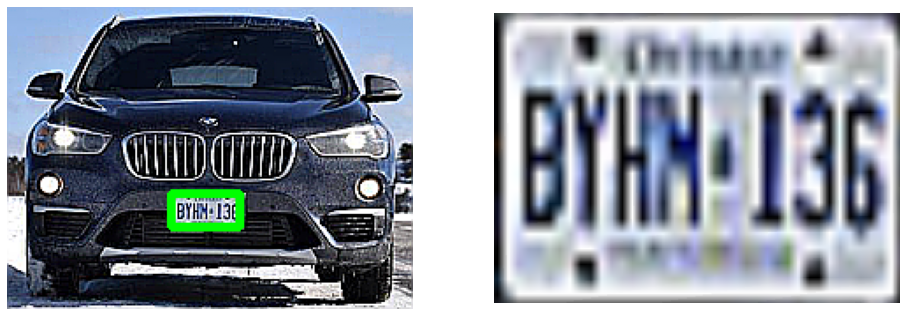

In [24]:
index = 20

image_paths = glob.glob("dataset/sharpness/images/*.png")
test_image = image_paths[index]
LpImg,cor = get_plate(test_image, Dmin=300)

X = cor[0][0]
Y = cor[0][1]
coor_predict = get_XY_coor(X, Y)
coor_label = labels[index][0]
print('IOU: ', IOU(coor_label, coor_predict))

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])
plt.savefig("result.jpg",dpi=80)

In [20]:
len(LpImg)

1